# 在 Rental Listing Inquiries 数据上练习分类方法
Rental Listing Inquiries 数据集是 Kaggle 平台上的一个分类竞赛任务，需要根据 公寓的特征来预测其受欢迎程度(用户感兴趣程度分为高、中、低三类)。其 中房屋的特征 x 共有 14 维，响应值 y 为用户对该公寓的感兴趣程度。评价标准为 logloss。

In [1]:
# import tool kit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# 评论标准为logloss
from sklearn.metrics import log_loss
%matplotlib inline

## 读取数据

In [2]:
# read train data, and look head info
train = pd.read_json("train.json")
train.head()

bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                    created  \
10      2016-06-24 07:54:24   
10000   2016-06-12 12:19:27   
100004  2016-04-17 03:26:41   
100007  2016-04-18 02:22:02   
100013  2016-04-28 01:32:41   

                                              description  \
10      A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000                                                       
100004  Top Top West Village location, beautiful Pre-w...   
100007  Building Amenities - Garage - Garden - fitness...   
100013  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Avenue   
10000       Columbus Avenue   
100004          W 13 Street   
100007     East 49th Street   
100013    West 143rd Street   

                                                 features interest_level  \
10                                                     []         medium   
10000   [Doorman, Elevator, Fitness Center, Cats Allow...            low   
100004  [Laundry In Building, Dishwasher, Hardwood Flo...           high   
100007                          [Hardwood Floors, No Fee]            low   
100013                                          [Pre-War]            low   

        latitude  listing_id  longitude                        manager_id  \
10       40.7145     7211212   -73.9425  5ba989232d0489da1b5f2c45f6688adc   
10000    40.7947     7150865   -73.9667  7533621a882f71e25173b27e3139d83d   
100004   40.7388     6887163   -74.0018  d9039c43983f6e564b1482b273bd7b01   
100007   40.7539     6888711   -73.9677  1067e078446a7897d2da493d2f741316   
100013   40.8241     6934781   -73.9493  98e13ad4b495b9613cef886d79a6291f   

                                                   photos  price  \
10      [https://photos.renthop.com/2/7211212_1ed4542e...   3000   
10000   [https://photos.renthop.com/2/7150865_be3306c5...   5465   
100004  [https://photos.renthop.com/2/6887163_de85c427...   2850   
100007  [https://photos.renthop.com/2/6888711_6e660cee...   3275   
100013  [https://photos.renthop.com/2/6934781_1fa4b41a...   3350   

                 street_address  
10      792 Metropolitan Avenue  
10000       808 Columbus Avenue  
100004          241 W 13 Street  
100007     333 East 49th Street  
100013    500 West 143rd Street

###### 数据类型相对比较多，特征14维，interest_level为y，分类结果为medium、low、high三种。特征中包含数字、类别、字符串、文本、图片等，需要对数据进行特征工程的处理。

In [3]:
# data info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


###### 所有特征数据没有空值数据，不需要做空值处理。

In [4]:
train.describe()

bathrooms      bedrooms      latitude    listing_id     longitude  \
count  49352.00000  49352.000000  49352.000000  4.935200e+04  49352.000000   
mean       1.21218      1.541640     40.741545  7.024055e+06    -73.955716   
std        0.50142      1.115018      0.638535  1.262746e+05      1.177912   
min        0.00000      0.000000      0.000000  6.811957e+06   -118.271000   
25%        1.00000      1.000000     40.728300  6.915888e+06    -73.991700   
50%        1.00000      1.000000     40.751800  7.021070e+06    -73.977900   
75%        1.00000      2.000000     40.774300  7.128733e+06    -73.954800   
max       10.00000      8.000000     44.883500  7.753784e+06      0.000000   

              price  
count  4.935200e+04  
mean   3.830174e+03  
std    2.206687e+04  
min    4.300000e+01  
25%    2.500000e+03  
50%    3.150000e+03  
75%    4.100000e+03  
max    4.490000e+06

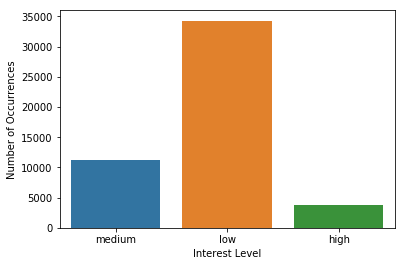

In [5]:
# target 分布，各类样本分布是否均衡
sns.countplot(train.interest_level)
plt.xlabel('Interest Level')
plt.ylabel('Number of Occurrences')
plt.show()

###### 兴趣为low的房子最多，其次是medium，兴趣为high的最少，和常理差不多。但和中国抢房的时期不同。

## 特征工程
对数值型特征进行分析。
bathrooms
bedrooms
price
latitude
longitude

### 单一变量分析

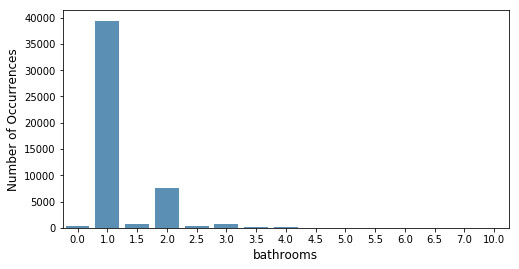

In [6]:
# Bathrooms
cnt_srs = train['bathrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


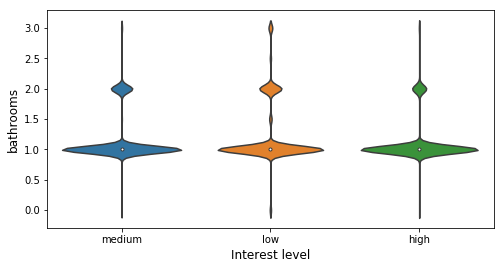

In [7]:
# bathrooms interest_level 核密度函数
train['bathrooms'].ix[train['bathrooms']>3] =3
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=train)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('bathrooms', fontsize=12)
plt.show()

###### 从概率密度函数上看，是均匀分布

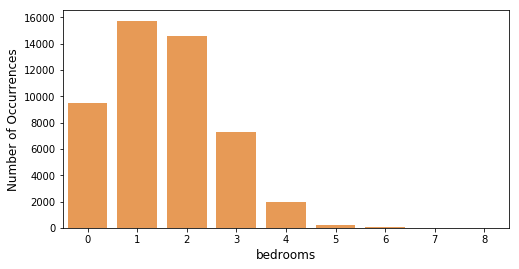

In [8]:
# bedrooms
cnt_srs = train['bedrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.show()

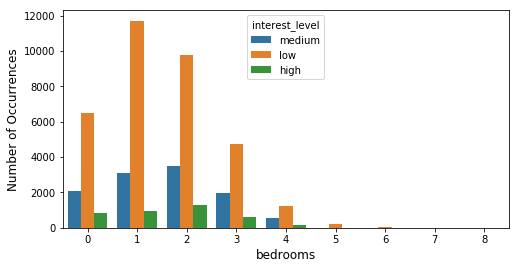

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x='bedrooms', hue='interest_level', data=train)
plt.xlabel('bedrooms', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

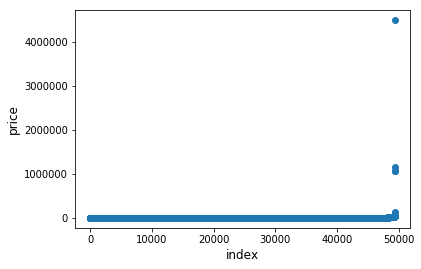

In [10]:
# price 价格的散点图
plt.scatter(range(train.shape[0]), np.sort(train.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

###### 从散布图上看，有3个点是离群点，我们把这几个点删除。

ulimit is : 13000.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


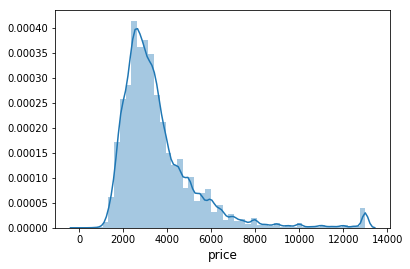

In [11]:
ulimit = np.percentile(train.price.values, 99)
print('ulimit is :', ulimit)
train['price'].ix[train['price']>ulimit] = ulimit

sns.distplot(train.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null float64
street_address     49352 non-null object
dtypes: float64(4), int64(2), object(9)
memory usage: 7.3+ MB


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


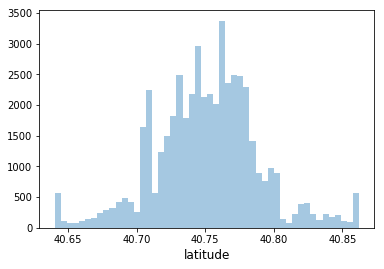

In [13]:
# 纬度
llimit = np.percentile(train.latitude.values, 1)
ulimit = np.percentile(train.latitude.values, 99)
train['latitude'].ix[train['latitude']<llimit] = llimit
train['latitude'].ix[train['latitude']>ulimit] = ulimit

sns.distplot(train.latitude.values, bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


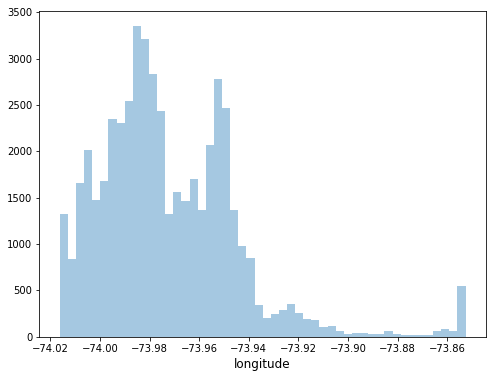

In [14]:
# 经度
# llimit = np.percentile(train.longitude.values, 1)
# ulimit = np.percentile(train.longitude.values, 99)
# train['longitude'].ix[train['longitude']<llimit] = llimit
# train['longitude'].ix[train['longitude']>ulimit] = ulimit

# sns.distplot(train.longitude.values, bins=50, kde=False)
# plt.xlabel('longitude', fontsize=12)
# plt.show()

llimit = np.percentile(train.longitude.values, 1)
ulimit = np.percentile(train.longitude.values, 99)
train['longitude'].ix[train['longitude']<llimit] = llimit
train['longitude'].ix[train['longitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train.longitude.values, bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.show()

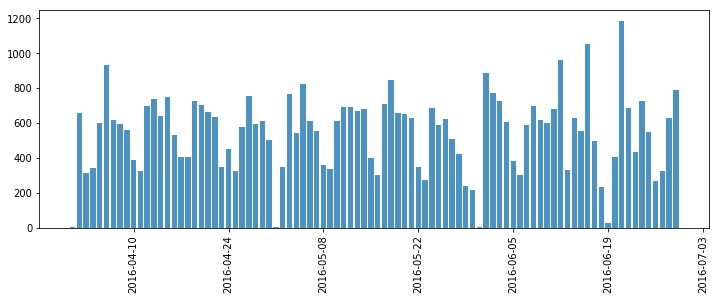

In [15]:
# created 日期
train["created"] = pd.to_datetime(train["created"])
train["date_created"] = train["created"].dt.date
cnt_srs = train['date_created'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

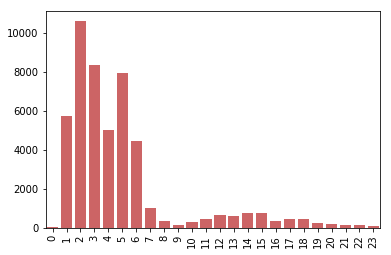

In [16]:
# 创建时间的 hour纬度
train["hour_created"] = train["created"].dt.hour
cnt_srs = train["hour_created"].value_counts()

sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

###### 创建的时间集中在凌晨的1点到7点。

dispaly address count:  display_address
                                           135
\tEast 10th Street and East 11th Street      1
\tWashington Street                          1
                                             2
  Allen street                               1
  Hell's Kitchen, Midtown  West              3
  Hell's Kitchen, Midtown West               2
  Hell's Kitchen, Midtown West               4
 11th Street                                 2
 17th Street                                 1
 1st Ave.                                    1
 1st ave                                     1
 236th Street                                1
 2nd Ave.                                    3
 2nd Street                                  1
 2nd ave                                     1
 30th Ave.                                   1
 30th Avenue                                 1
 32nd St.                                    2
 330 east 30th street                        1
 38th St.           

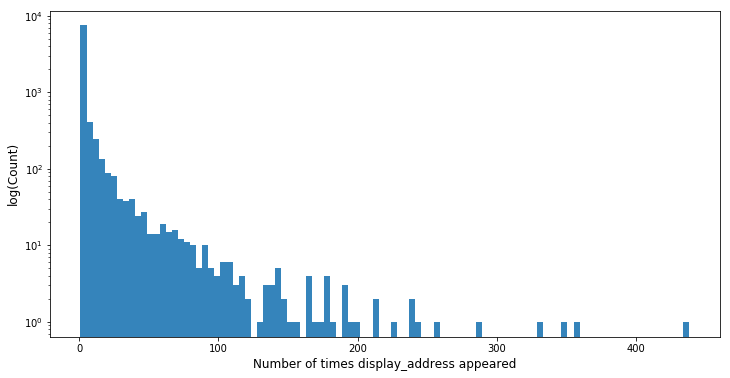

In [17]:
# display_address 
cnt_srs = train.groupby('display_address')['display_address'].count()
print("dispaly address count: ", cnt_srs)

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times {}%'.format(i, round((cnt_srs < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_srs.values, bins=100, log=True, alpha=0.9)
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

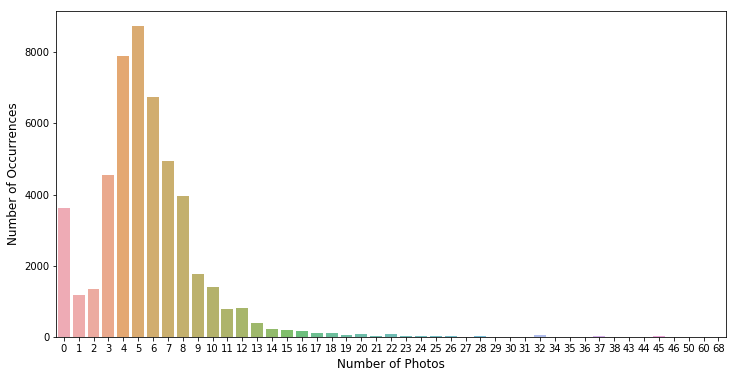

In [18]:
# number of photos
train["num_photos"] = train["photos"].apply(len)
cnt_srs = train['num_photos'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel("Number of Photos", fontsize=12)
plt.ylabel("Number of Occurrences", fontsize=12)
plt.show()

features value counts : 3     6211
4     5459
2     4938
5     4547
1     4340
6     3835
7     3374
0     3218
8     2840
9     2453
10    2217
11    1681
12    1377
13    1009
14     737
15     456
16     283
17     161
18      89
19      45
20      24
21      14
22      13
26       8
23       6
24       5
28       3
27       3
25       2
39       1
36       1
32       1
31       1
Name: num_features, dtype: int64


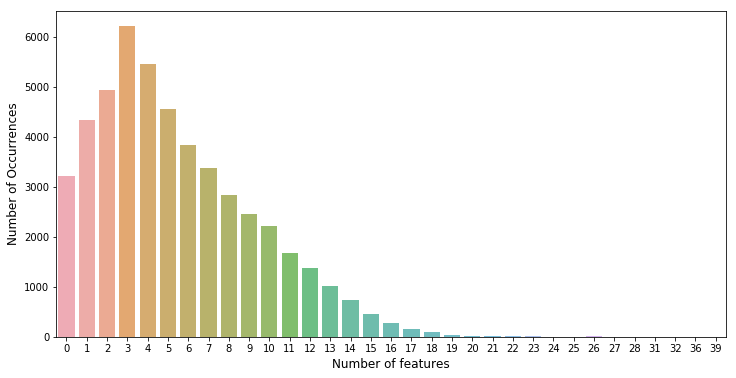

In [19]:
# num of feature
train["num_features"] = train["features"].apply(len)
cnt_srs = train['num_features'].value_counts()
print("features value counts :", cnt_srs)

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of features', fontsize=12)
plt.show()

### 处理特征值及创新新的特征

In [20]:
# 处理object数据
train.head()

bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                   created                                        description  \
10     2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000  2016-06-12 12:19:27                                                      
100004 2016-04-17 03:26:41  Top Top West Village location, beautiful Pre-w...   
100007 2016-04-18 02:22:02  Building Amenities - Garage - Garden - fitness...   
100013 2016-04-28 01:32:41  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Avenue   
10000       Columbus Avenue   
100004          W 13 Street   
100007     East 49th Street   
100013    West 143rd Street   

                                                 features interest_level  \
10                                                     []         medium   
10000   [Doorman, Elevator, Fitness Center, Cats Allow...            low   
100004  [Laundry In Building, Dishwasher, Hardwood Flo...           high   
100007                          [Hardwood Floors, No Fee]            low   
100013                                          [Pre-War]            low   

        latitude  listing_id  longitude                        manager_id  \
10       40.7145     7211212   -73.9425  5ba989232d0489da1b5f2c45f6688adc   
10000    40.7947     7150865   -73.9667  7533621a882f71e25173b27e3139d83d   
100004   40.7388     6887163   -74.0018  d9039c43983f6e564b1482b273bd7b01   
100007   40.7539     6888711   -73.9677  1067e078446a7897d2da493d2f741316   
100013   40.8241     6934781   -73.9493  98e13ad4b495b9613cef886d79a6291f   

                                                   photos   price  \
10      [https://photos.renthop.com/2/7211212_1ed4542e...  3000.0   
10000   [https://photos.renthop.com/2/7150865_be3306c5...  5465.0   
100004  [https://photos.renthop.com/2/6887163_de85c427...  2850.0   
100007  [https://photos.renthop.com/2/6888711_6e660cee...  3275.0   
100013  [https://photos.renthop.com/2/6934781_1fa4b41a...  3350.0   

                 street_address date_created  hour_created  num_photos  \
10      792 Metropolitan Avenue   2016-06-24             7           5   
10000       808 Columbus Avenue   2016-06-12            12          11   
100004          241 W 13 Street   2016-04-17             3           8   
100007     333 East 49th Street   2016-04-18             2           3   
100013    500 West 143rd Street   2016-04-28             1           3   

        num_features  
10                 0  
10000              5  
100004             4  
100007             2  
100013             1

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 19 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null datetime64[ns]
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null float64
street_address     49352 non-null object
date_created       49352 non-null object
hour_created       49352 non-null int64
num_photos         49352 non-null int64
num_features       49352 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(9)
memory usage: 8.8+ MB


In [22]:
# 读入测试数据，为特征处理做准备
test = pd.read_json("test.json")
test.head()

bathrooms  bedrooms                       building_id  \
0             1.0         1  79780be1514f645d7e6be99a3de696c5   
1             1.0         2                                 0   
100           1.0         1  3dbbb69fd52e0d25131aa1cd459c87eb   
1000          1.0         2  783d21d013a7e655bddc4ed0d461cc5e   
100000        2.0         2  6134e7c4dd1a98d9aee36623c9872b49   

                    created  \
0       2016-06-11 05:29:41   
1       2016-06-24 06:36:34   
100     2016-06-03 04:29:40   
1000    2016-06-11 06:17:35   
100000  2016-04-12 05:24:17   

                                              description  \
0       Large with awesome terrace--accessible via bed...   
1       Prime Soho - between Bleecker and Houston - Ne...   
100             New York chic has reached a new level ...   
1000    Step into this fantastic new Construction in t...   
100000  ~Take a stroll in Central Park, enjoy the ente...   

              display_address  \
0              Suffolk Street   
1             Thompson Street   
100      101 East 10th Street   
1000     South Third Street\r   
100000  Midtown West, 8th Ave   

                                                 features  latitude  \
0       [Elevator, Laundry in Building, Laundry in Uni...   40.7185   
1                   [Pre-War, Dogs Allowed, Cats Allowed]   40.7278   
100                           [Doorman, Elevator, No Fee]   40.7306   
1000    [Roof Deck, Balcony, Elevator, Laundry in Buil...   40.7109   
100000  [Common Outdoor Space, Cats Allowed, Dogs Allo...   40.7650   

        listing_id  longitude                        manager_id  \
0          7142618   -73.9865  b1b1852c416d78d7765d746cb1b8921f   
1          7210040   -74.0000  d0b5648017832b2427eeb9956d966a14   
100        7103890   -73.9890  9ca6f3baa475c37a3b3521a394d65467   
1000       7143442   -73.9571  0b9d5db96db8472d7aeb67c67338c4d2   
100000     6860601   -73.9845  b5eda0eb31b042ce2124fd9e9fcfce2f   

                                                   photos  price  \
0       [https://photos.renthop.com/2/7142618_1c45a2c8...   2950   
1       [https://photos.renthop.com/2/7210040_d824cc71...   2850   
100     [https://photos.renthop.com/2/7103890_85b33077...   3758   
1000    [https://photos.renthop.com/2/7143442_0879e9e0...   3300   
100000  [https://photos.renthop.com/2/6860601_c96164d8...   4900   

                   street_address  
0               99 Suffolk Street  
1             176 Thompson Street  
100          101 East 10th Street  
1000    251  South Third Street\r  
100000       260 West 54th Street

In [23]:
# 数字化特征值 
# hour_created       49352 non-null int64
# num_photos         49352 non-null int64
# num_features  
def numberical(df):
    df['num_description_words'] = df['description'].apply(lambda x: len(x.split(" ")))
    df['created'] = pd.to_datetime(df['created'])
    df['year_created'] = df['created'].dt.year
    df['month_created'] = df['created'].dt.month
    df['day_created'] = df['created'].dt.day
    df['hour_created'] = df['created'].dt.hour
    df['num_photos'] = df['photos'].apply(len)
    df['num_features'] = df['features'].apply(len)
    
    return df
train = numberical(train)
test = numberical(test)

In [24]:
train.head()

bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                   created                                        description  \
10     2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000  2016-06-12 12:19:27                                                      
100004 2016-04-17 03:26:41  Top Top West Village location, beautiful Pre-w...   
100007 2016-04-18 02:22:02  Building Amenities - Garage - Garden - fitness...   
100013 2016-04-28 01:32:41  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Avenue   
10000       Columbus Avenue   
100004          W 13 Street   
100007     East 49th Street   
100013    West 143rd Street   

                                                 features interest_level  \
10                                                     []         medium   
10000   [Doorman, Elevator, Fitness Center, Cats Allow...            low   
100004  [Laundry In Building, Dishwasher, Hardwood Flo...           high   
100007                          [Hardwood Floors, No Fee]            low   
100013                                          [Pre-War]            low   

        latitude  listing_id     ...        price           street_address  \
10       40.7145     7211212     ...       3000.0  792 Metropolitan Avenue   
10000    40.7947     7150865     ...       5465.0      808 Columbus Avenue   
100004   40.7388     6887163     ...       2850.0          241 W 13 Street   
100007   40.7539     6888711     ...       3275.0     333 East 49th Street   
100013   40.8241     6934781     ...       3350.0    500 West 143rd Street   

       date_created  hour_created num_photos num_features  \
10       2016-06-24             7          5            0   
10000    2016-06-12            12         11            5   
100004   2016-04-17             3          8            4   
100007   2016-04-18             2          3            2   
100013   2016-04-28             1          3            1   

        num_description_words  year_created  month_created  day_created  
10                         95          2016              6           24  
10000                       9          2016              6           12  
100004                     94          2016              4           17  
100007                     80          2016              4           18  
100013                     68          2016              4           28  

[5 rows x 23 columns]

In [25]:
test.head()

bathrooms  bedrooms                       building_id  \
0             1.0         1  79780be1514f645d7e6be99a3de696c5   
1             1.0         2                                 0   
100           1.0         1  3dbbb69fd52e0d25131aa1cd459c87eb   
1000          1.0         2  783d21d013a7e655bddc4ed0d461cc5e   
100000        2.0         2  6134e7c4dd1a98d9aee36623c9872b49   

                   created                                        description  \
0      2016-06-11 05:29:41  Large with awesome terrace--accessible via bed...   
1      2016-06-24 06:36:34  Prime Soho - between Bleecker and Houston - Ne...   
100    2016-06-03 04:29:40          New York chic has reached a new level ...   
1000   2016-06-11 06:17:35  Step into this fantastic new Construction in t...   
100000 2016-04-12 05:24:17  ~Take a stroll in Central Park, enjoy the ente...   

              display_address  \
0              Suffolk Street   
1             Thompson Street   
100      101 East 10th Street   
1000     South Third Street\r   
100000  Midtown West, 8th Ave   

                                                 features  latitude  \
0       [Elevator, Laundry in Building, Laundry in Uni...   40.7185   
1                   [Pre-War, Dogs Allowed, Cats Allowed]   40.7278   
100                           [Doorman, Elevator, No Fee]   40.7306   
1000    [Roof Deck, Balcony, Elevator, Laundry in Buil...   40.7109   
100000  [Common Outdoor Space, Cats Allowed, Dogs Allo...   40.7650   

        listing_id  longitude      ...       \
0          7142618   -73.9865      ...        
1          7210040   -74.0000      ...        
100        7103890   -73.9890      ...        
1000       7143442   -73.9571      ...        
100000     6860601   -73.9845      ...        

                                                   photos price  \
0       [https://photos.renthop.com/2/7142618_1c45a2c8...  2950   
1       [https://photos.renthop.com/2/7210040_d824cc71...  2850   
100     [https://photos.renthop.com/2/7103890_85b33077...  3758   
1000    [https://photos.renthop.com/2/7143442_0879e9e0...  3300   
100000  [https://photos.renthop.com/2/6860601_c96164d8...  4900   

                   street_address num_description_words  year_created  \
0               99 Suffolk Street                    78          2016   
1             176 Thompson Street                    35          2016   
100          101 East 10th Street                   333          2016   
1000    251  South Third Street\r                   204          2016   
100000       260 West 54th Street                   174          2016   

        month_created  day_created  hour_created  num_photos  num_features  
0                   6           11             5           8             6  
1                   6           24             6           3             3  
100                 6            3             4           6             3  
1000                6           11             6           6            10  
100000              4           12             5           7            14  

[5 rows x 21 columns]

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 23 columns):
bathrooms                49352 non-null float64
bedrooms                 49352 non-null int64
building_id              49352 non-null object
created                  49352 non-null datetime64[ns]
description              49352 non-null object
display_address          49352 non-null object
features                 49352 non-null object
interest_level           49352 non-null object
latitude                 49352 non-null float64
listing_id               49352 non-null int64
longitude                49352 non-null float64
manager_id               49352 non-null object
photos                   49352 non-null object
price                    49352 non-null float64
street_address           49352 non-null object
date_created             49352 non-null object
hour_created             49352 non-null int64
num_photos               49352 non-null int64
num_features             49352 non-n

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 21 columns):
bathrooms                74659 non-null float64
bedrooms                 74659 non-null int64
building_id              74659 non-null object
created                  74659 non-null datetime64[ns]
description              74659 non-null object
display_address          74659 non-null object
features                 74659 non-null object
latitude                 74659 non-null float64
listing_id               74659 non-null int64
longitude                74659 non-null float64
manager_id               74659 non-null object
photos                   74659 non-null object
price                    74659 non-null int64
street_address           74659 non-null object
num_description_words    74659 non-null int64
year_created             74659 non-null int64
month_created            74659 non-null int64
day_created              74659 non-null int64
hour_created             74659 non-null i

In [28]:
# interest_level category to number
train.replace({"interest_level" : {"low":0, "medium":1, "high":2}}, inplace=True)
train.head()

bathrooms  bedrooms                       building_id  \
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
100013        1.0         4                                 0   

                   created                                        description  \
10     2016-06-24 07:54:24  A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
10000  2016-06-12 12:19:27                                                      
100004 2016-04-17 03:26:41  Top Top West Village location, beautiful Pre-w...   
100007 2016-04-18 02:22:02  Building Amenities - Garage - Garden - fitness...   
100013 2016-04-28 01:32:41  Beautifully renovated 3 bedroom flex 4 bedroom...   

            display_address  \
10      Metropolitan Avenue   
10000       Columbus Avenue   
100004          W 13 Street   
100007     East 49th Street   
100013    West 143rd Street   

                                                 features  interest_level  \
10                                                     []               1   
10000   [Doorman, Elevator, Fitness Center, Cats Allow...               0   
100004  [Laundry In Building, Dishwasher, Hardwood Flo...               2   
100007                          [Hardwood Floors, No Fee]               0   
100013                                          [Pre-War]               0   

        latitude  listing_id     ...        price           street_address  \
10       40.7145     7211212     ...       3000.0  792 Metropolitan Avenue   
10000    40.7947     7150865     ...       5465.0      808 Columbus Avenue   
100004   40.7388     6887163     ...       2850.0          241 W 13 Street   
100007   40.7539     6888711     ...       3275.0     333 East 49th Street   
100013   40.8241     6934781     ...       3350.0    500 West 143rd Street   

       date_created  hour_created num_photos num_features  \
10       2016-06-24             7          5            0   
10000    2016-06-12            12         11            5   
100004   2016-04-17             3          8            4   
100007   2016-04-18             2          3            2   
100013   2016-04-28             1          3            1   

        num_description_words  year_created  month_created  day_created  
10                         95          2016              6           24  
10000                       9          2016              6           12  
100004                     94          2016              4           17  
100007                     80          2016              4           18  
100013                     68          2016              4           28  

[5 rows x 23 columns]

In [29]:
# 获取最终的特征，去除object列，并对数据进行标准化
from sklearn.preprocessing import StandardScaler
def fillna_numerical_train(df):
    numerical_features = df.select_dtypes(exclude=['object']).columns
    
    numerical_features = numerical_features.drop(['interest_level', 'created', 'listing_id'])
    print("Numerical features : " + str(len(numerical_features)))
    df_num = df[numerical_features]
    df_num.info()
    
    medians = df_num.median()
    print("NAS for numerical features in df : " + str(df_num.isnull().values.sum()))
    
    ss_X = StandardScaler()
    # 对训练特征标准化处理
    temp = ss_X.fit_transform(df_num)
    df_num = pd.DataFrame(data=temp, columns=numerical_features, index=df_num.index)
    
    return df_num, medians, ss_X

train_num, medians, ss_X = fillna_numerical_train(train)

Numerical features : 12
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 12 columns):
bathrooms                49352 non-null float64
bedrooms                 49352 non-null int64
latitude                 49352 non-null float64
longitude                49352 non-null float64
price                    49352 non-null float64
hour_created             49352 non-null int64
num_photos               49352 non-null int64
num_features             49352 non-null int64
num_description_words    49352 non-null int64
year_created             49352 non-null int64
month_created            49352 non-null int64
day_created              49352 non-null int64
dtypes: float64(4), int64(8)
memory usage: 6.1 MB
NAS for numerical features in df : 0


In [30]:
train_num.head()

bathrooms  bedrooms  latitude  longitude     price  hour_created  \
10       0.628742  1.307938 -0.954215   1.069327 -0.329264      0.533454   
10000   -0.439700  0.411083  1.135833   0.208964  1.003907      1.726699   
100004  -0.439700 -0.485772 -0.320946  -1.038917 -0.410390     -0.421141   
100007  -0.439700 -0.485772  0.072567   0.173412 -0.180533     -0.659790   
100013  -0.439700  2.204793  1.902011   0.827572 -0.139970     -0.898439   

        num_photos  num_features  num_description_words  year_created  \
10       -0.167099     -1.383625               0.081856           0.0   
10000     1.484771     -0.109210              -1.366111           0.0   
100004    0.658836     -0.364093               0.065019           0.0   
100007   -0.717723     -0.873859              -0.170696           0.0   
100013   -0.717723     -1.128742              -0.372738           0.0   

        month_created  day_created  
10           1.194938     1.061886  
10000        1.194938    -0.387273  
100004      -1.230969     0.216543  
100007      -1.230969     0.337306  
100013      -1.230969     1.544939

In [31]:
# 对测试数据集做正规化处理
def fillna_numerical_test(df, medians, ss_X):
    numerical_features = df.select_dtypes(exclude=['object']).columns
    
    numerical_features = numerical_features.drop(['created', 'listing_id'])
    print("Numerical features : " + str(len(numerical_features)))
    df_num = df[numerical_features]
    df_num.info()
    
    print("NAS for numerical features in df : " + str(df_num.isnull().values.sum()))
    
    # 对训练特征标准化处理
    temp = ss_X.transform(df_num)
    df_num = pd.DataFrame(data=temp, columns=numerical_features, index=df_num.index)
    
    return df_num

test_num = fillna_numerical_test(test, medians, ss_X)

Numerical features : 12
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 12 columns):
bathrooms                74659 non-null float64
bedrooms                 74659 non-null int64
latitude                 74659 non-null float64
longitude                74659 non-null float64
price                    74659 non-null int64
num_description_words    74659 non-null int64
year_created             74659 non-null int64
month_created            74659 non-null int64
day_created              74659 non-null int64
hour_created             74659 non-null int64
num_photos               74659 non-null int64
num_features             74659 non-null int64
dtypes: float64(3), int64(9)
memory usage: 7.4 MB
NAS for numerical features in df : 0


In [32]:
test_num.describe()

bathrooms      bedrooms      latitude     longitude         price  \
count  74659.000000  74659.000000  74659.000000  74659.000000  74659.000000   
mean       0.015274      0.002712     -0.418414      0.970424      0.075843   
std        1.388589      0.992831     21.022619     52.894348      5.253230   
min       -2.576584     -1.382628  -1061.992448  -1689.276808     -1.951244   
25%       -0.439700     -0.485772     -0.607611     -0.683395     -0.602388   
50%       -0.439700     -0.485772      0.012628     -0.182110     -0.248138   
75%       -0.439700      0.411083      0.604200      0.635591      0.265660   
max      236.754421      4.895359     55.289451   2629.886337    903.955484   

       num_description_words  year_created  month_created   day_created  \
count           74659.000000  7.465900e+04   74659.000000  74659.000000   
mean               20.363521  5.534847e+02      -0.105199     -1.262537   
std                14.503132  8.927887e-10       0.210486      0.138827   
min                -0.898439  5.534847e+02      -0.364093     -1.500805   
25%                10.795358  5.534847e+02      -0.364093     -1.382948   
50%                18.670773  5.534847e+02      -0.109210     -1.265090   
75%                27.262134  5.534847e+02       0.145672     -1.147232   
max               675.909919  5.534847e+02       0.145672     -0.995701   

       hour_created    num_photos  num_features  
count  74659.000000  74659.000000  74659.000000  
mean   -2011.200913      0.734250     -1.181462  
std        4.216924      4.416828      0.473050  
min    -2016.000000     -6.082784     -1.836432  
25%    -2014.000000     -1.230969     -1.594906  
50%    -2012.000000     -0.018015     -1.232616  
75%    -2011.000000      2.407892     -0.870326  
max    -1993.000000     54.564901      2.511045

## 模型训练

#### default Logistic Regression

In [33]:
X_train = train_num;
y_train = train['interest_level']

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

#交叉验证用于评估模型性能和参数调优
from sklearn.cross_validation import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_log_loss')

print('logloss of each flod is :', -loss)
print('cv logloss is :', -loss.mean())

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


logloss of each flod is : [ 0.7112944   0.70173328  0.70115019  0.69560879  0.7080214 ]
cv logloss is : 0.703561610822


#### 正则化 Logistic Regression及参数调优

###### logistic回归需要调整参数 ：C(正则系数)和正则函数penalty(l1/l2)
目标函数 ：J = sum(logloss(f(xi), yi)) + C*penalty

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 需要调优的参数
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty = LogisticRegression()
grid = GridSearchCV(lr_penalty, tuned_parameters, cv=5, scoring='neg_log_loss')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [35]:
grid.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([ 0.14738679,  0.28696318,  0.32025437,  0.37293901,  0.32484965,
         0.38022242,  0.36275182,  0.38692923,  0.33541875,  0.37472062,
         0.35885463,  0.3941596 ,  0.35209723,  0.38731341]),
 'mean_score_time': array([ 0.00660782,  0.00493479,  0.00511642,  0.00515079,  0.00525355,
         0.00462971,  0.00535421,  0.00488162,  0.00497594,  0.00472274,
         0.00485473,  0.0045733 ,  0.00520554,  0.00509725]),
 'mean_test_score': array([-0.75848363, -0.74471114, -0.70644758, -0.70739773, -0.70364527,
        -0.70370344, -0.70355931, -0.70356134, -0.70355312, -0.70355311,
        -0.70355233, -0.70355236, -0.70355235, -0.70355228]),
 'mean_train_score': array([-0.75819317, -0.74029452, -0.70562047, -0.70638565, -0.70274425,
        -0.70280045, -0.70265132, -0.70265333, -0.70264429, -0.7026443 ,
        -0.70264358, -0.70264346, -0.70264348, -0.70264337]),
 'param_C': masked_array(data = [0.001 0.001 0.01 0.01 0.1 0.1 1 1 10 10 100 100 1000 1000],


In [36]:
# best model
print(-grid.best_score_)
print(grid.best_params_)

0.703552281431
{'C': 1000, 'penalty': 'l2'}


In [37]:
c = grid.best_params_['C']
print('best c is %d:', c)
TryCs = [c * .6, c * .65, c * .7, c * .75, c * .8, c * .85,
            c * .9, c * .95, c * 1.05, c * 1.1, c * 1.15, c * 1.2,
            c * 1.25, c * 1.3, c * 1.35, c * 1.4, c * 1.45, c * 1.5]

tuned_parameters = dict(penalty = penaltys, C = TryCs)
try_grid = GridSearchCV(lr_penalty, tuned_parameters, cv=5, scoring='neg_log_loss')
try_grid.fit(X_train, y_train)

best c is %d: 1000


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1050.0, 1100.0, 1150.0, 1200.0, 1250.0, 1300.0, 1350.0, 1400.0, 1450.0, 1500.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [38]:
# try the best model
print(try_grid.best_score_)
print(try_grid.best_params_)

-0.703552059684
{'C': 650.0, 'penalty': 'l1'}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


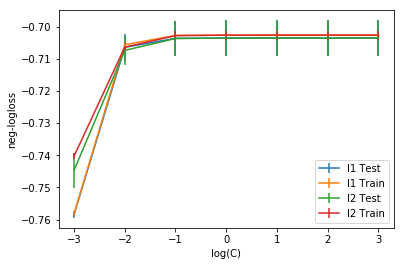

In [39]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    plt.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    plt.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'neg-logloss' )
plt.savefig('LogisticGridSearchCV_C.png' )

plt.show()

###### 从上图中可以看出，不同正则参数 C对应的模型在训练集和测试集上的准确度。C越大性能越好。在C=125表现最好。6

### 用LogisticRegressionCV实现正则化的Logistic Regression

###### L1 正则

In [40]:
from sklearn.linear_model import LogisticRegressionCV
Cs = [1, 10, 100, 1000]

lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv=5, scoring='neg_log_loss', penalty='l1', solver='liblinear', multi_class='ovr')
lrcv_L1.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1, 10, 100, 1000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [41]:
lrcv_L1.scores_

{0: array([[-0.54340214, -0.54340966, -0.54341089, -0.54341098],
        [-0.53587829, -0.53587599, -0.53587572, -0.53587576],
        [-0.53450123, -0.53449647, -0.53449623, -0.53449612],
        [-0.53302044, -0.53301563, -0.53301535, -0.53301538],
        [-0.5427782 , -0.54278382, -0.54278478, -0.54278488]]),
 1: array([[-0.50318642, -0.5031915 , -0.50319203, -0.50319234],
        [-0.49822479, -0.49822361, -0.49822353, -0.49822347],
        [-0.49730623, -0.4973032 , -0.49730275, -0.49730276],
        [-0.49915174, -0.49915117, -0.49915134, -0.49915128],
        [-0.50039076, -0.50039206, -0.50039221, -0.50039203]]),
 2: array([[-0.240258  , -0.24026662, -0.24026747, -0.24026776],
        [-0.23715782, -0.23715783, -0.23715783, -0.2371579 ],
        [-0.23788742, -0.23788788, -0.23788789, -0.23788792],
        [-0.23045617, -0.23043563, -0.23043347, -0.23043373],
        [-0.24016385, -0.24017606, -0.24017721, -0.24017759]])}

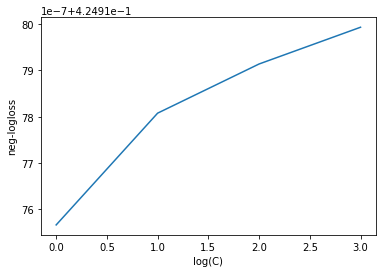

In [42]:
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lrcv_L1.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
plt.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

In [43]:
# 稀疏系数
lrcv_L1.coef_

array([[-0.25512138, -0.68040224,  0.06505373,  0.18761707,  1.78290365,
        -0.28575801, -0.05433009, -0.27625447, -0.14402877,  0.        ,
         0.03696219,  0.06481819],
       [ 0.14874239,  0.49804475, -0.02665443, -0.16849733, -1.16673575,
         0.17594662,  0.0432708 ,  0.23657727,  0.13097876,  0.        ,
        -0.02955205, -0.03086307],
       [ 0.27671015,  0.69676424, -0.05182085, -0.17876623, -2.46983529,
         0.28337883,  0.02776769,  0.22181392,  0.08194432,  0.        ,
        -0.02834173, -0.11347016]])

#### L2正则

In [44]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [1, 10,100,1000]
lr_cv_L2 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l2', solver='liblinear', multi_class='ovr')
lr_cv_L2.fit(X_train, y_train)    

LogisticRegressionCV(Cs=[1, 10, 100, 1000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [45]:
lr_cv_L2.scores_

{0: array([[-0.54340478, -0.54341082, -0.54341143, -0.5434115 ],
        [-0.53588157, -0.53587585, -0.53587528, -0.53587523],
        [-0.53449953, -0.53449621, -0.53449588, -0.53449585],
        [-0.53301809, -0.53301521, -0.53301493, -0.5330149 ],
        [-0.54277819, -0.54278435, -0.54278498, -0.54278504]]),
 1: array([[-0.50318894, -0.50319219, -0.50319252, -0.50319255],
        [-0.49822562, -0.49822335, -0.49822313, -0.49822311],
        [-0.49730511, -0.49730287, -0.49730265, -0.49730262],
        [-0.49914889, -0.49915105, -0.49915127, -0.49915129],
        [-0.50039224, -0.50039226, -0.50039227, -0.50039227]]),
 2: array([[-0.24025607, -0.24026623, -0.24026734, -0.24026746],
        [-0.2371623 , -0.23715814, -0.23715781, -0.23715778],
        [-0.23787713, -0.23788695, -0.23788802, -0.23788813],
        [-0.23047791, -0.23043822, -0.23043429, -0.2304339 ],
        [-0.24015206, -0.24017501, -0.24017741, -0.24017765]])}

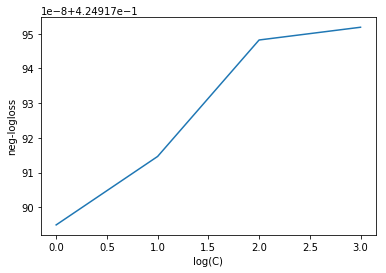

In [46]:
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lr_cv_L2.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
plt.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

## SVM模型训练

#### default SVC

In [48]:
# train_test_split 估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [49]:
from sklearn.svm import LinearSVC

SVC1 = LinearSVC().fit(X_train_part, y_train_part)

In [50]:
# 在校验集上测试，估计模型性能
from sklearn import metrics
y_predict = SVC1.predict(X_val)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, metrics.classification_report(y_val, y_predict)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_val, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       0.71      0.98      0.82      6897
          1       0.39      0.07      0.11      2221
          2       0.00      0.00      0.00       753

avg / total       0.58      0.70      0.60      9871


Confusion matrix:
[[6750  147    0]
 [2073  148    0]
 [ 669   84    0]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 线性SVM正则参数调优

In [51]:
def fit_grid_point_Linear(C, X_train, y_train, X_val, y_val):
    SVC2 = LinearSVC(C = C)
    SVC2 = SVC2.fit(X_train, y_train)
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_val, y_val)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

accuracy: 0.7000303920575423
accuracy: 0.6994225509066964
accuracy: 0.6990173234727991
accuracy: 0.6990173234727991
accuracy: 0.6982068686050046
accuracy: 0.669435720798298
accuracy: 0.6246580893526492


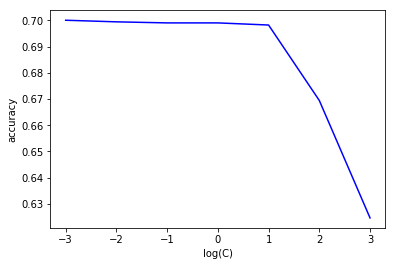

In [52]:
#需要调优的参数
C_s = np.logspace(-3, 3, 7)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份  
#penalty_s = ['l1','l2']

accuracy_s = []
for i, oneC in enumerate(C_s):
#    for j, penalty in enumerate(penalty_s):
    tmp = fit_grid_point_Linear(oneC, X_train, y_train, X_val, y_val)
    accuracy_s.append(tmp)

x_axis = np.log10(C_s)
#for j, penalty in enumerate(penalty_s):
plt.plot(x_axis, np.array(accuracy_s), 'b-')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.savefig('SVM_Otto.png' )

plt.show()

### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。 RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma C越小，决策边界越平滑； gamma越小，决策边界越平滑。

In [57]:
from sklearn.svm import SVC

In [59]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    # 在训练集使用SVC训练
    SVC3 = SVC(C=C, kernel='rbf', gamma=gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 校验集上返回accuracy
    accuracy = SVC3.score(X_val, y_val)
    
    print('accuracy :{}'.format(accuracy))
    return accuracy

In [60]:
#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_val, y_val)
        accuracy_s.append(tmp)

accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6990173234727991
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.6987134028973762
accuracy :0.7128963630837808
accuracy :0.8489514740147908
accuracy :0.9929085199067977
accuracy :0.9978725559720393
accuracy :0.6995238577651707
accuracy :0.7493668321345355
accuracy :0.9787255597203931
accuracy :0.9984803971228852
accuracy :0.9987843176983082
accuracy :0.7033735183871949
accuracy :0.7990071927869516
accuracy :0.9982777834059365
accuracy :0.9987843176983082
accuracy :0.9988856245567825


In [ ]:
C_s = np.logspace(-1, 2, 4)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-5, -2, 4)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_val, y_val)
        accuracy_s.append(tmp)

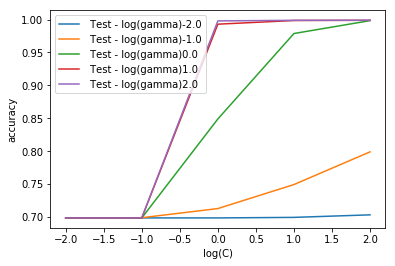

In [61]:
accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))

plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.savefig('RBF_SVM_Otto.png' )

plt.show()

 gamma越大，对应RBF核的sigma越小，决策边界更复杂，可能发生了过拟合。

#### 进行最终的预测

In [87]:
SVC_finall = SVC(C=C_s[4], kernel='rbf', gamma=gamma_s[4])
SVC_finall = SVC_finall.fit(X_train, y_train)

# 校验集上返回accuracy
accuracy = SVC_finall.score(X_val, y_val)
    
print('accuracy :{}'.format(accuracy))

accuracy :0.9988856245567825


In [67]:
y = SVC_finall.predict(test_num)

In [70]:
labels2idx = {label: i for i, label in enumerate(SVC_finall.classes_)}
labels2idx

{0: 0, 1: 1, 2: 2}

In [86]:
# 导出数据
sub = pd.DataFrame()
sub['listing_id'] = test['listing_id']
sub['interesting_level'] = y

sub.head()
sub.to_csv("submission_rf.csv", index=False)

listing_id  interesting_level
0          7142618                  0
1          7210040                  0
100        7103890                  0
1000       7143442                  0
100000     6860601                  0